# Prédiction de Pannes avec XGBoost et Calibration des Probabilités

## Problématique

Dans de nombreux systèmes industriels, la prédiction des pannes est necessaire pour la maintenance préventive et la réduction des temps d'arrêt. Cependant, les pannes sont souvent des événements rares, ce qui rend la tâche de prédiction difficile. Ce notebook présente une approche pour prédire les pannes en utilisant un modèle de classification XGBoost, suivi d'une calibration des probabilités pour améliorer la fiabilité des prédictions.

Nous simulons également le cas où il y a de nouvelle données rentrée par l'utilisateur de facons à observé les cas de dérive des données.

## Objectifs

1. **Générer un Dataset Synthétique** : Utiliser `make_classification` de `sklearn` pour créer un dataset avec des pannes rares.
2. **Enregistrer les Données dans PostgreSQL** : Sauvegarder les données générées dans une base de données PostgreSQL.
3. **Charger les Données depuis PostgreSQL** : Charger les données pour l'entraînement et l'évaluation du modèle.
4. **Entraîner un Modèle XGBoost** : Entraîner un modèle XGBoost pour la classification binaire (panne/non-panne).
5. **Calibrer les Probabilités** : Utiliser `CalibratedClassifierCV` pour calibrer les probabilités sorties par le modèle.
6. **Évaluer les Performances** : Calculer les métriques AUC et Log Loss pour évaluer la performance du modèle.
7. **Interprétabilité avec SHAP** : Utiliser SHAP pour expliquer les prédictions du modèle.
8. **Détection de Drift** : Mesurer le drift des données et réentraîner le modèle si nécessaire.
9. **Suivi avec MLflow** : Utiliser MLflow pour suivre les paramètres, les métriques et le modèle.

## Configuration de la Base de Données PostgreSQL

Pour stocker et charger les données générées, nous allons utiliser une base de données PostgreSQL. Voici les étapes pour créer la base de données et la table nécessaire.

### Installation de PostgreSQL sur Ubuntu

Ouvrez un terminal et exécutez les commandes suivantes pour installer PostgreSQL :

```sudo apt install postgresql postgresql-contrib```

### Démarrage du Service PostgreSQL

Démarrez le service PostgreSQL :

```sudo systemctl start postgresql```

Activez le service PostgreSQL pour qu'il démarre automatiquement au démarrage du système :

```sudo systemctl enable postgresql```

### Connexion à PostgreSQL

Passez à l'utilisateur PostgreSQL :

```sudo -i -u postgres```

Connectez-vous à l'interface de ligne de commande PostgreSQL :

```psql```

### Étapes pour Créer la Base de Données et la Table

1. **Connexion à PostgreSQL** :
   - Assurez-vous que PostgreSQL est installé et en cours d'exécution sur votre machine.
   - Utilisez un client PostgreSQL comme `psql` ou un outil comme pgAdmin pour exécuter les commandes SQL.

2. **Création de la Base de Données** :
   - Connectez-vous à PostgreSQL en tant qu'utilisateur avec des privilèges pour créer des bases de données.
   - Exécutez la commande suivante pour créer une nouvelle base de données nommée `mlflow_drift_detection` :
     ```sql
     CREATE DATABASE mlflow_drift_detection;
     ```

## Tests Effectués

- **AUC (Area Under the Curve)** : Mesure de la capacité du modèle à distinguer entre les classes.
- **Log Loss** : Mesure de la performance du modèle en termes de probabilités prédites.
- **Visualisation SHAP** : Interprétabilité des prédictions du modèle.

## Conclusion

Ce notebook présente une approche complète pour la prédiction de pannes en utilisant un modèle XGBoost calibré. Les résultats sont suivis avec MLflow pour assurer la reproductibilité et la traçabilité des expériences.

---

# Code

Le code ci-dessous implémente les étapes décrites ci-dessus. Chaque étape est encapsulée dans une classe pour une meilleure modularité et maintenabilité.

In [ ]:
!pip install -q numpy pandas xgboost shap scikit-learn mlflow psycopg2

In [ ]:
# Importer les bibliothèques nécessaires
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import mlflow
import mlflow.sklearn
import psycopg2
from psycopg2.extras import execute_values
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, log_loss
from xgboost import XGBClassifier

In [ ]:
# Spécifier un répertoire personnalisé pour stocker les artefacts MLflow
mlflow.set_tracking_uri("file:/path/to/your/custom/mlruns")

In [ ]:
# Configuration de la connexion à PostgreSQL
DB_CONFIG = {
    'dbname': 'mlflow_drift_detection',
    'user': 'your_username',
    'password': 'your_password',
    'host': 'your_host',
    'port': 'your_port'
}

In [19]:
# Classe pour la génération du dataset
class DataGenerator:
    def __init__(self, n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
                 n_clusters_per_class=1, weights=[0.9, 0.1], flip_y=0, random_state=42):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_informative = n_informative
        self.n_redundant = n_redundant
        self.n_clusters_per_class = n_clusters_per_class
        self.weights = weights
        self.flip_y = flip_y
        self.random_state = random_state

    def generate_data(self):
        X, y = make_classification(n_samples=self.n_samples, n_features=self.n_features,
                                   n_informative=self.n_informative, n_redundant=self.n_redundant,
                                   n_clusters_per_class=self.n_clusters_per_class,
                                   weights=self.weights, flip_y=self.flip_y, random_state=self.random_state)
        return train_test_split(X, y, test_size=0.2, random_state=self.random_state)

    def save_to_db(self, X_train, X_test, y_train, y_test):
        conn = psycopg2.connect(**DB_CONFIG)
        cur = conn.cursor()

        # Insérer les données dans les tables
        train_data = [(str(list(x)), int(y)) for x, y in zip(X_train, y_train)]
        test_data = [(str(list(x)), int(y)) for x, y in zip(X_test, y_test)]

        execute_values(cur, "INSERT INTO train_data (feature_vector, label) VALUES %s", train_data)
        execute_values(cur, "INSERT INTO test_data (feature_vector, label) VALUES %s", test_data)

        conn.commit()
        cur.close()
        conn.close()

# Classe pour l'entraînement du modèle XGBoost
class XGBoostModel:
    def __init__(self):
        self.model = XGBClassifier(eval_metric='logloss')

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def get_model(self):
        return self.model

# Classe pour la calibration du modèle
class ModelCalibrator:
    def __init__(self, model):
        self.calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)

    def calibrate(self, X_train, y_train):
        self.calibrated_model.fit(X_train, y_train)

    def get_calibrated_model(self):
        return self.calibrated_model

# Classe pour l'évaluation du modèle
class ModelEvaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self):
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(self.y_test, y_pred_proba)
        logloss = log_loss(self.y_test, y_pred_proba)
        return auc, logloss

# Classe pour l'interprétabilité avec SHAP
class SHAPExplainer:
    def __init__(self, model, X_train, X_test):
        self.explainer = shap.Explainer(model, X_train)
        self.shap_values = self.explainer(X_test)
        self.X_test = X_test  # Stocker X_test pour l'utiliser dans la méthode plot

    def plot(self):
        shap.summary_plot(self.shap_values.values, self.X_test)

# Classe pour mesurer le drift des données
class DataDriftDetector:
    def __init__(self, base_model, new_data):
        self.base_model = base_model
        self.new_data = new_data

    def detect_drift(self):
        # Implémenter une méthode pour détecter le drift des données
        # Par exemple, comparer les distributions des caractéristiques
        # ou utiliser des techniques de détection de drift comme Population Stability Index (PSI)
        # Pour simplifier, nous allons retourner False pour l'instant
        return False

# Classe principale pour orchestrer le processus
class MainPipeline:
    def __init__(self):
        self.data_generator = DataGenerator()

    def load_data_from_db(self):
        conn = psycopg2.connect(**DB_CONFIG)
        cur = conn.cursor()

        # Charger les données depuis les tables
        cur.execute("SELECT feature_vector, label FROM train_data")
        train_data = cur.fetchall()
        cur.execute("SELECT feature_vector, label FROM test_data")
        test_data = cur.fetchall()

        cur.close()
        conn.close()

        # Convertir les données en numpy arrays
        X_train = np.array([eval(row[0]) for row in train_data])
        y_train = np.array([row[1] for row in train_data])
        X_test = np.array([eval(row[0]) for row in test_data])
        y_test = np.array([row[1] for row in test_data])

        return X_train, X_test, y_train, y_test

    def run(self):
        # Vérifier si une run MLflow est déjà active et la terminer
        if mlflow.active_run():
            mlflow.end_run()

        # Initialisation de MLflow
        mlflow.start_run()

        # Génération du dataset
        X_train, X_test, y_train, y_test = self.data_generator.generate_data()

        # Enregistrement des données dans PostgreSQL
        self.data_generator.save_to_db(X_train, X_test, y_train, y_test)

        # Chargement des données depuis PostgreSQL
        X_train, X_test, y_train, y_test = self.load_data_from_db()

        # Entraînement du modèle XGBoost
        xgb_model = XGBoostModel()
        xgb_model.train(X_train, y_train)

        # Calibration du modèle
        model_calibrator = ModelCalibrator(xgb_model.get_model())
        model_calibrator.calibrate(X_train, y_train)
        calibrated_model = model_calibrator.get_calibrated_model()

        # Évaluation du modèle
        model_evaluator = ModelEvaluator(calibrated_model, X_test, y_test)
        auc, logloss = model_evaluator.evaluate()

        # Logging des paramètres et des métriques avec MLflow
        mlflow.log_param("model", "XGBClassifier")
        mlflow.log_param("calibration", "sigmoid")
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("log_loss", logloss)

        # Logging du modèle avec MLflow (utiliser mlflow.sklearn pour le modèle calibré)
        mlflow.sklearn.log_model(calibrated_model, "model")

        # Interprétabilité avec SHAP (utiliser le modèle XGBoost sous-jacent)
        shap_explainer = SHAPExplainer(xgb_model.get_model(), X_train, X_test)
        shap_explainer.plot()

        # Détection de drift des données
        drift_detector = DataDriftDetector(xgb_model.get_model(), X_test)
        drift_detected = drift_detector.detect_drift()

        if drift_detected:
            # Réentraîner le modèle si un drift est détecté
            xgb_model.train(X_train, y_train)
            model_calibrator.calibrate(X_train, y_train)
            calibrated_model = model_calibrator.get_calibrated_model()
            mlflow.sklearn.log_model(calibrated_model, "model_retrained")

        # Fin de la run MLflow
        mlflow.end_run()

2025/04/13 12:55:34 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/13 12:55:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


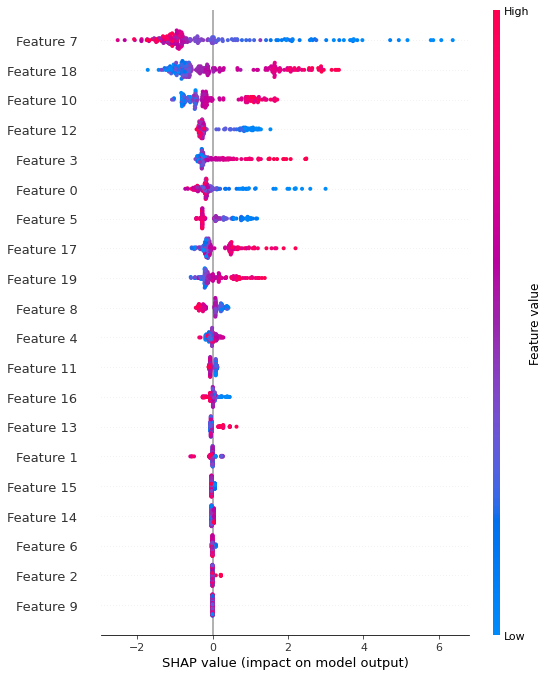

In [14]:
# Exécution de la pipeline principale
pipeline = MainPipeline()
pipeline.run()

# Monitoring avec MLflow

Pour visualiser les runs MLflow, suivez ces étapes :

1. **Démarrer le Serveur MLflow** :
   - Ouvrez un terminal et exécutez la commande suivante :
     ```bash
     mlflow ui
     ```

2. **Accéder à l'Interface Utilisateur Web** :
   - Ouvrez un navigateur web et accédez à [http://localhost:5000](http://localhost:5000).

3. **Explorer les Runs** :
   - Dans l'interface utilisateur de MLflow, vous verrez une liste des runs exécutés.
   - Cliquez sur un run pour voir les détails, y compris les paramètres, les métriques, et les artefacts.

# Exemple de Run

- **Run ID** : [Run ID](http://localhost:5000/#/experiments/0/runs/<run_id>)
- **Modèle Enregistré** : [Modèle](http://localhost:5000/#/experiments/0/runs/<run_id>/artifactPath/model)

In [15]:
# Pour tester, vous pouver lancer ici
!mlflow ui

[2025-04-13 12:57:50 +0200] [17524] [INFO] Starting gunicorn 23.0.0
[2025-04-13 12:57:50 +0200] [17524] [INFO] Listening at: http://127.0.0.1:5000 (17524)
[2025-04-13 12:57:50 +0200] [17524] [INFO] Using worker: sync
[2025-04-13 12:57:50 +0200] [17525] [INFO] Booting worker with pid: 17525
[2025-04-13 12:57:50 +0200] [17526] [INFO] Booting worker with pid: 17526
[2025-04-13 12:57:50 +0200] [17527] [INFO] Booting worker with pid: 17527
[2025-04-13 12:57:50 +0200] [17528] [INFO] Booting worker with pid: 17528
^C
[2025-04-13 13:50:55 +0200] [17524] [INFO] Handling signal: int
[2025-04-13 13:50:55 +0200] [17526] [INFO] Worker exiting (pid: 17526)
[2025-04-13 13:50:55 +0200] [17527] [INFO] Worker exiting (pid: 17527)
[2025-04-13 13:50:55 +0200] [17528] [INFO] Worker exiting (pid: 17528)
[2025-04-13 13:50:55 +0200] [17525] [INFO] Worker exiting (pid: 17525)
